# Data Preparation

In [1]:
from numpy import asarray
from numpy import save
from predictor.driver import Predictor
from predictor.src import utils
from predictor.driver import Predictor
from predictor.src import utils

import numpy as np

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

training_data, names_list, scores_list = utils.load_training_data()
X, y = zip(*training_data)
X = list(X)
y = list(y)
for i in range(len(X)):
    X[i] = list(X[i])
    scores_list[i] = list(scores_list[i])

X, y, indices = np.array(X), np.array(y), np.array(range(len(y)))

non_zero_indices = []
for i in range(len(X[0])):
    if sum(X[:, i]) > 0:
        non_zero_indices.append(i)
X = X[:, non_zero_indices]

(
    X_train,
    X_test,
    y_train,
    y_test,
    indices_train,
    indices_test,
) = train_test_split(X, y, indices, test_size=0.3, random_state=5)

scores_filtered = [scores_list[i] for i in indices_test]

# scaler = preprocessing.StandardScaler().fit(X_train)
# in_max_scaler = preprocessing.MinMaxScaler()

# X_train = preprocessing.normalize(X_train, norm='l2')

# m = np.mean(X_train, axis=0) # array([16.25, 26.25])
# std = np.std(X_train, axis=0) # array([17.45530005, 22.18529919])

# X_train = 0.5 * (np.tanh(0.01 * ((X_train - m) / std)) + 1)

predictor = Predictor()
performance=[]

# Current Decision Tree Classifier

In [2]:
#predictor.train_decision_tree_classifier(X, y, names_list, scores_list);

/Users/nils/opt/anaconda3/envs/quantum/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


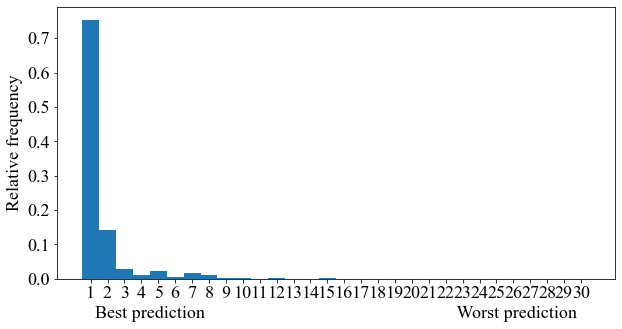

Best Accuracy:  0.7524685213756035
Top 3:  0.9243421052631579
Feature Importance:  [0.021893   0.         0.         0.03567263 0.         0.
 0.         0.04952939 0.         0.         0.         0.
 0.         0.         0.         0.         0.00481344 0.
 0.         0.         0.33377769 0.13789793 0.04844336 0.128165
 0.10049397 0.10130024 0.03801337]


In [3]:
from sklearn import tree
from sklearn.model_selection import GridSearchCV

clf = tree.DecisionTreeClassifier(random_state=5)

tree_param = [
    {
        "criterion": ["entropy", "gini"],
        "max_depth": list(range(1, 15, 1)),
        "min_samples_split": list(range(2, 20, 4)),
        "min_samples_leaf": list(range(2, 20, 4)),
        "max_leaf_nodes": list(range(2, 200, 40)),
        "max_features": list(range(1, len(non_zero_indices), 10)),
    },
]
clf = GridSearchCV(clf, tree_param, cv=5, n_jobs=8).fit(X_train, y_train)
y_pred = np.array(list(clf.predict(X_test)))
res = predictor.plot_eval_histogram(scores_filtered, y_pred, y_test)

print("Best Accuracy: ", clf.best_score_)
top3 = (res.count(1) + res.count(2) + res.count(3)) / len(res)
print("Top 3: ", top3)
print("Feature Importance: ", clf.best_estimator_.feature_importances_)
performance.append(("DecisionTreeClassifier", clf.best_score_, top3))

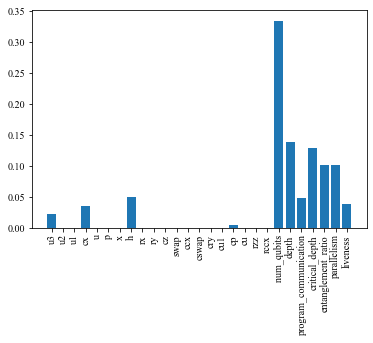

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

openqasm_qc_list = utils.get_openqasm_gates()
feature_names = [openqasm_qc_list[i] for i in range(0, len(openqasm_qc_list))]
feature_names.append("num_qubits")
feature_names.append("depth")
feature_names.append("program_communication")
feature_names.append("critical_depth")
feature_names.append("entanglement_ratio")
feature_names.append("parallelism")
feature_names.append("liveness")
feature_names = [feature_names[i] for i in non_zero_indices]

plt.bar(feature_names, clf.best_estimator_.feature_importances_)
plt.xticks(rotation=90)
plt.show()

# Random Forest

/Users/nils/opt/anaconda3/envs/quantum/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/Users/nils/opt/anaconda3/envs/quantum/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


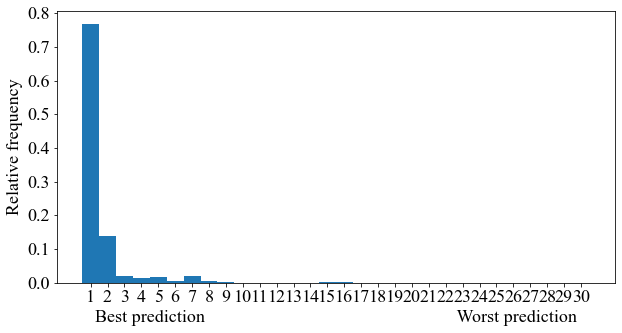

Best Accuracy:  0.768665704474195
Top 3:  0.9276315789473685
Feature Importance:  [4.58856321e-02 8.46584828e-03 3.96082304e-04 7.97031897e-02
 5.29609282e-03 2.39775607e-04 9.59958568e-03 3.50920591e-02
 9.86908164e-04 7.42271571e-03 6.14097706e-03 1.41800925e-02
 1.68590841e-03 0.00000000e+00 5.00283552e-04 3.91132902e-04
 2.42313573e-02 1.56087605e-05 1.21474501e-03 3.73649642e-04
 1.61006351e-01 9.10119346e-02 6.80152426e-02 1.05327426e-01
 1.10521606e-01 1.14717485e-01 1.07578310e-01]


In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV

clf = RandomForestClassifier(random_state=0)

tree_param = [
    {
        "n_estimators": [10, 100, 200],
        "max_features": ["auto", "sqrt"],
        "max_depth": list(range(1, 30, 5)),
        "min_samples_split": list(range(2, 20, 5)),
        "min_samples_leaf": list(range(2, 20, 5)),
        "bootstrap": [True, False],
    },
]

clf = GridSearchCV(clf, tree_param, cv=5, n_jobs=8).fit(X_train, y_train)


y_pred = np.array(list(clf.predict(X_test)))
res = predictor.plot_eval_histogram(scores_filtered, y_pred, y_test)

print("Best Accuracy: ", clf.best_score_)
top3 = (res.count(1) + res.count(2) + res.count(3)) / len(res)
print("Top 3: ", top3)
print("Feature Importance: ", clf.best_estimator_.feature_importances_)
performance.append(("RandomForestClassifier", clf.best_score_, top3))
random_forest_feature_importances = clf.best_estimator_.feature_importances_

### Feature Importances

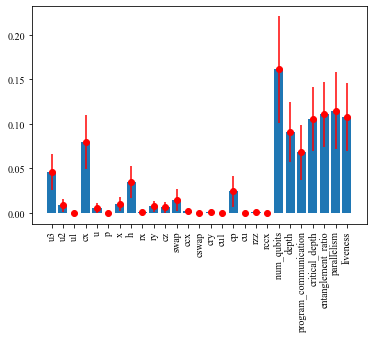

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

openqasm_qc_list = utils.get_openqasm_gates()
feature_names = [openqasm_qc_list[i] for i in range(0, len(openqasm_qc_list))]
feature_names.append("num_qubits")
feature_names.append("depth")
feature_names.append("program_communication")
feature_names.append("critical_depth")
feature_names.append("entanglement_ratio")
feature_names.append("parallelism")
feature_names.append("liveness")
feature_names = [feature_names[i] for i in non_zero_indices]

importances = random_forest_feature_importances
std = np.std([tree.feature_importances_ for tree in clf.best_estimator_.estimators_], axis=0)

plt.bar(feature_names, random_forest_feature_importances)
plt.errorbar(feature_names, random_forest_feature_importances, std, fmt="o", color="r")
plt.xticks(rotation=90)
plt.show()

# Nearest Neighbor

/Users/nils/opt/anaconda3/envs/quantum/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


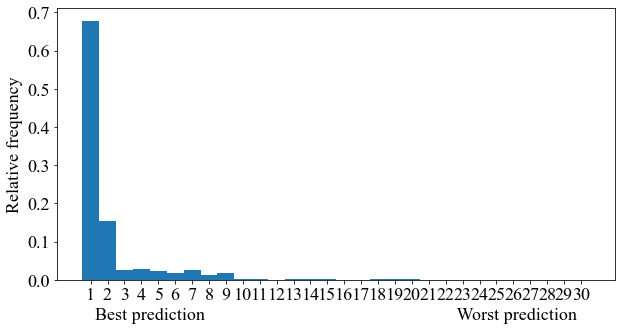

Best Accuracy:  0.6741701089931817
('Top 3: ', 0.8569078947368421)


In [7]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier()
param_grid = dict(n_neighbors=range(1, 10, 1))
clf = GridSearchCV(clf, param_grid, cv=5, n_jobs=8).fit(X_train, y_train)

y_pred = np.array(list(clf.predict(X_test)))
res = predictor.plot_eval_histogram(scores_filtered, y_pred, y_test)

print("Best Accuracy: ", clf.best_score_)
top3 = (res.count(1) + res.count(2) + res.count(3)) / len(res)
print(("Top 3: ", top3))
performance.append(("KNeighborsClassifier", clf.best_score_, top3))

# SVM

/Users/nils/opt/anaconda3/envs/quantum/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


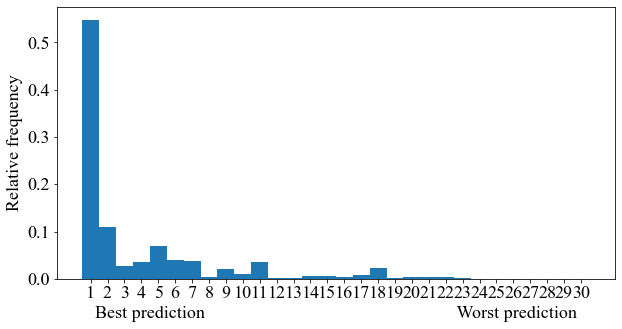

Best Accuracy:  0.5550365799034489
Top 3:  0.6858552631578947


In [8]:
from sklearn import svm

clf = svm.SVC()
param_grid = {"C": [0.1, 1, 10], "gamma": [1, 0.1, 0.01], "kernel": ["rbf", "sigmoid"]}
clf = GridSearchCV(clf, param_grid, cv=5, n_jobs=8).fit(X_train, y_train)

y_pred = np.array(list(clf.predict(X_test)))
res = predictor.plot_eval_histogram(scores_filtered, y_pred, y_test)

print("Best Accuracy: ", clf.best_score_)
top3 = (res.count(1) + res.count(2) + res.count(3)) / len(res)
print("Top 3: ", top3)
performance.append(("SVM", clf.best_score_, top3))

# Naive Bayes

/Users/nils/opt/anaconda3/envs/quantum/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


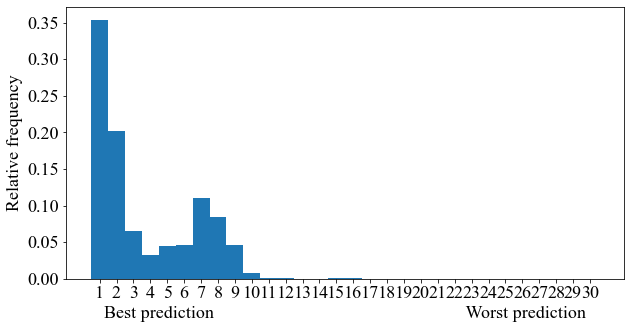

Best Accuracy:  0.29546359428656743
Top 3:  0.6217105263157895


In [9]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
param_grid = {"var_smoothing": np.logspace(0, -9, num=100)}
clf = GridSearchCV(clf, param_grid, cv=5, n_jobs=8).fit(X_train, y_train)

y_pred = np.array(list(clf.predict(X_test)))
res = predictor.plot_eval_histogram(scores_filtered, y_pred, y_test)

print("Best Accuracy: ", clf.best_score_)
top3 = (res.count(1) + res.count(2) + res.count(3)) / len(res)
print("Top 3: ", top3)
performance.append(("Naive Bayes", clf.best_score_, top3))

# SGD

/Users/nils/opt/anaconda3/envs/quantum/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


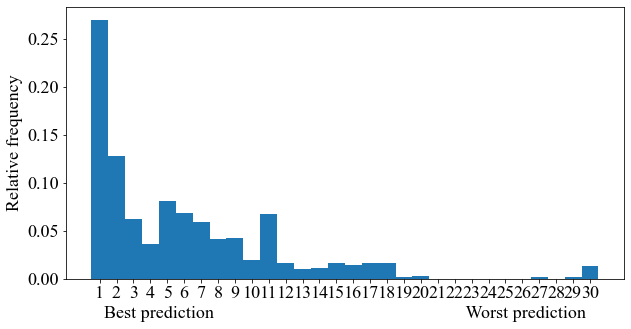

Best Accuracy:  0.23206589359478427
Top 3:  0.4605263157894737


In [10]:
from sklearn.linear_model import SGDClassifier

clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=200)

param_grid = {
    "average": [True, False],
    "l1_ratio": np.linspace(0, 1, num=10),
    "alpha": np.power(10, np.arange(-2, 1, dtype=float)),
}
clf = GridSearchCV(clf, param_grid, cv=5, n_jobs=8).fit(X_train, y_train)

y_pred = np.array(list(clf.predict(X_test)))
res = predictor.plot_eval_histogram(scores_filtered, y_pred, y_test)

print("Best Accuracy: ", clf.best_score_)
top3 = (res.count(1) + res.count(2) + res.count(3)) / len(res)
print("Top 3: ", top3)
performance.append(("SGDClassifier", clf.best_score_, top3))

# GradientBoostingClassifier

/Users/nils/opt/anaconda3/envs/quantum/lib/python3.9/site-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


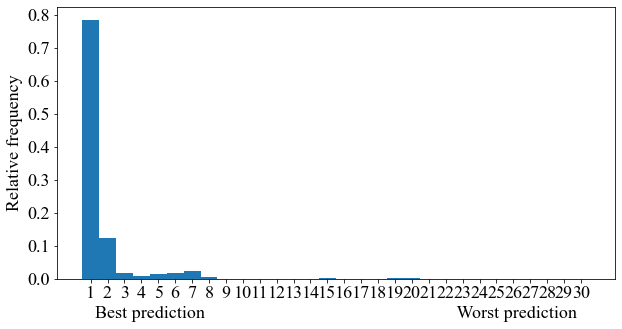

Best Accuracy:  0.7630244363708754
Top 3:  0.9259868421052632


In [11]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier()

param_grid = {
    "learning_rate": [0.01, 0.1, 1],
}

clf = GridSearchCV(clf, param_grid, cv=5, n_jobs=8).fit(X_train, y_train)

y_pred = np.array(list(clf.predict(X_test)))
res = predictor.plot_eval_histogram(scores_filtered, y_pred, y_test)

print("Best Accuracy: ", clf.best_score_)
top3 = (res.count(1) + res.count(2) + res.count(3)) / len(res)
print("Top 3: ", top3)
performance.append(("GradientBoostingClassifier", clf.best_score_, top3))

In [12]:
performance

[('DecisionTreeClassifier', 0.7524685213756035, 0.9243421052631579),
 ('RandomForestClassifier', 0.768665704474195, 0.9276315789473685),
 ('KNeighborsClassifier', 0.6741701089931817, 0.8569078947368421),
 ('SVM', 0.5550365799034489, 0.6858552631578947),
 ('Naive Bayes', 0.29546359428656743, 0.6217105263157895),
 ('SGDClassifier', 0.23206589359478427, 0.4605263157894737),
 ('GradientBoostingClassifier', 0.7630244363708754, 0.9259868421052632)]

# Debugging